# Heartbeat classification using an LSTM model with attention mechanism

In [1]:
# Imports
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from sklearn.metrics import * 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, LSTM, Lambda, Dot, Activation, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import activations
from sklearn.preprocessing import normalize
from itertools import islice
length = 277

### Extract task-specific data and one-hot encode labels

In [3]:
# Load the training and testing data:
train_values = np.empty(shape=[0, length])
test_values = np.empty(shape=[0, length])

train_beats = glob.glob('./train_beats.csv')
test_beats = glob.glob('./test_beats.csv')

for j in train_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    train_values = np.append(train_values, csvrows, axis=0)

for j in test_beats:
    print('Loading ', j)
    csvrows = np.loadtxt(j, delimiter=',')
    test_values = np.append(test_values, csvrows, axis=0)
    
print(train_values.shape)
print(test_values.shape)

# Separate the training and testing data:
X_train = train_values[:,:-2]
X_test = test_values[:,:-2]

X_train = np.reshape(X_train, (-1, X_train.shape[1], 1))
X_test = np.reshape(X_test, (-1, X_test.shape[1], 1))

y_train = train_values[:,-2]
y_test = test_values[:,-2]

# One-hot encode labels:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Loading  ../../../mimic3-code-main/module2_week1/train_beats.csv
Loading  ../../../mimic3-code-main/module2_week1/test_beats.csv
(31912, 277)
(37863, 277)


### Build the LSTM architecture with the attention mechanism and train the model
We will train the attention model twice: once for only 5 epochs, and once for 100 epochs. We do this so that we can afterwards compare the model's prediction performance and the interpretability of the model (in the next practical exercise).

In [4]:
# The attention mechanism:
# We used the implementation from https://github.com/philipperemy/keras-attention-mechanism
def attention_layer(x):
    score_first_part = Dense(9)(x)
    h_t = Lambda(lambda x: x[:, -1, :], output_shape=(9,), name='last_hidden_state')(x)
    score = Dot(axes=[1, 2], name='attention_score')([h_t, score_first_part])
    attention_weights = Activation('softmax', name='attention_weight')(score)
    context_vector = Dot(axes=[1, 1], name='context_vector')([x, attention_weights])
    pre_activation = Concatenate(name='attention_output')([context_vector, h_t])
    attention_vector = Dense(275, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)    
    return attention_vector

# The LSTM model with attention mechanism:
def getAttentionModel():
    attnmodel = Sequential()
    model_input = Input(shape=(X_train.shape[1],X_train.shape[2]))
    attnmodel = LSTM(128, return_sequences=True)(model_input)
    attnmodel = LSTM(9, return_sequences=True)(attnmodel)
    attnmodel = attention_layer(attnmodel)
    attnmodel = Dense(9, activation='softmax')(attnmodel)
    attnmodel = Model(model_input, attnmodel)
    attnmodel.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
    return attnmodel
    
attention_model = getAttentionModel()
attention_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 275, 1)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 275, 128)     66560       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 275, 9)       4968        lstm[0][0]                       
__________________________________________________________________________________________________
last_hidden_state (Lambda)      (None, 9)            0           lstm_1[0][0]                     
______________________________________________________________________________________________

In [12]:
# Train the model for five epochs, make a prediction on the test dataset, and save the weights:
attention_model = getAttentionModel()
attnhistory5 = attention_model.fit(X_train, y_train, epochs = 5, verbose = 1, validation_split = 0.2, batch_size = 256)
attnpredictions5 = attention_model.predict(X_test, verbose=1)
attention_model.save_weights('./checkpoints/attention_model_5_epochs2')

Epoch 1/5
100/100 [==============================] - 79s 760ms/step - loss: 1.6959 - accuracy: 0.3750 - val_loss: 1.3117 - val_accuracy: 0.5295
Epoch 2/5
100/100 [==============================] - 78s 781ms/step - loss: 1.1565 - accuracy: 0.5978 - val_loss: 0.9256 - val_accuracy: 0.6801
Epoch 3/5
100/100 [==============================] - 81s 810ms/step - loss: 0.8645 - accuracy: 0.7086 - val_loss: 0.7610 - val_accuracy: 0.7518
Epoch 4/5
100/100 [==============================] - 81s 814ms/step - loss: 0.7095 - accuracy: 0.7675 - val_loss: 0.6110 - val_accuracy: 0.7987
Epoch 5/5
1184/1184 [==============================] - 55s 46ms/step


In [5]:
# Train the model for hundred epochs, make a prediction on the test dataset, and save the weights:
attention_model = getAttentionModel()
attnhistory100 = attention_model.fit(X_train, y_train, epochs = 100, verbose = 1, validation_split = 0.2, batch_size = 256)
attnpredictions100 = attention_model.predict(X_test, verbose=1)
attention_model.save_weights('./checkpoints/attention_model_100_epochs')

Epoch 1/100
100/100 [==============================] - 73s 710ms/step - loss: 1.7660 - accuracy: 0.3373 - val_loss: 1.4901 - val_accuracy: 0.5034
Epoch 2/100
100/100 [==============================] - 73s 731ms/step - loss: 1.3275 - accuracy: 0.5265 - val_loss: 1.1002 - val_accuracy: 0.6090
Epoch 3/100
100/100 [==============================] - 75s 754ms/step - loss: 1.0206 - accuracy: 0.6422 - val_loss: 0.9572 - val_accuracy: 0.6699
Epoch 4/100
100/100 [==============================] - 75s 753ms/step - loss: 0.8795 - accuracy: 0.7017 - val_loss: 0.7658 - val_accuracy: 0.7514
Epoch 5/100
100/100 [==============================] - 75s 747ms/step - loss: 0.7481 - accuracy: 0.7485 - val_loss: 0.6755 - val_accuracy: 0.7791
Epoch 6/100
100/100 [==============================] - 75s 753ms/step - loss: 0.6437 - accuracy: 0.7866 - val_loss: 0.5358 - val_accuracy: 0.8302
Epoch 7/100
100/100 [==============================] - 76s 757ms/step - loss: 0.5151 - accuracy: 0.8337 - val_loss: 0.4970 -

Epoch 57/100
100/100 [==============================] - 77s 768ms/step - loss: 0.0639 - accuracy: 0.9791 - val_loss: 0.1279 - val_accuracy: 0.9643
Epoch 58/100
100/100 [==============================] - 76s 764ms/step - loss: 0.0621 - accuracy: 0.9801 - val_loss: 0.1115 - val_accuracy: 0.9704
Epoch 59/100
100/100 [==============================] - 78s 779ms/step - loss: 0.0517 - accuracy: 0.9833 - val_loss: 0.1109 - val_accuracy: 0.9691
Epoch 60/100
100/100 [==============================] - 78s 783ms/step - loss: 0.0441 - accuracy: 0.9864 - val_loss: 0.1138 - val_accuracy: 0.9671
Epoch 61/100
100/100 [==============================] - 77s 773ms/step - loss: 0.0469 - accuracy: 0.9843 - val_loss: 0.1139 - val_accuracy: 0.9718
Epoch 62/100
100/100 [==============================] - 77s 768ms/step - loss: 0.0682 - accuracy: 0.9785 - val_loss: 0.1216 - val_accuracy: 0.9685
Epoch 63/100
100/100 [==============================] - 77s 769ms/step - loss: 0.0592 - accuracy: 0.9803 - val_loss: 0

In [10]:
# Save the model so we can visualize it with Netron (https://github.com/lutzroeder/netron):
tf.keras.models.save_model(attention_model, 'lstm_attention_model.h5')

### Visualize the training and validation loss and accuracy

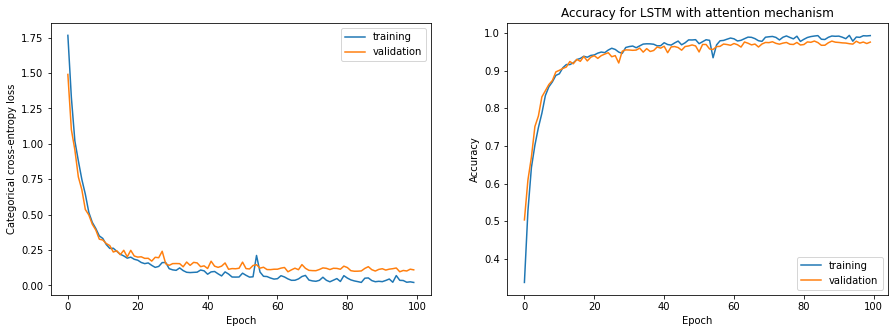

In [7]:
# Visualize the performance metrics over epochs:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

# Loss:
ax[0].plot(attnhistory100.history['loss'], label = 'training')
ax[0].plot(attnhistory100.history['val_loss'], label = 'validation')
ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Categorical cross-entropy loss')
ax[1].set_title('Loss for LSTM with attention mechanism')

# Accuracy:
ax[1].plot(attnhistory100.history['accuracy'], label = 'training')
ax[1].plot(attnhistory100.history['val_accuracy'], label = 'validation')
ax[1].legend(loc = 'lower right')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy for LSTM with attention mechanism')
fig.savefig('lstm_attention_loss_accuracy_ecg_data.jpg', dpi = 400)

### Create a performance metrics function

In [13]:
def showResults(test, pred, model_name):
    accuracy = accuracy_score(test, pred)
    precision= precision_score(test, pred, average='macro')
    recall = recall_score(test, pred, average = 'macro')
    f1score= f1_score(test, pred, average='macro') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("Recall : {}".format(recall))
    print("f1score : {}".format(f1score))
    cm=confusion_matrix(test, pred, labels=[1,2,3,4,5,6,7,8])
    return (model_name, round(accuracy,3), round(precision,3) , round(recall,3) , round(f1score,3), cm)

### Compute and visualize performance metrics for both models (5 and 100 epochs of training)

In [46]:
# Get the class predictions and the actual labels:
attn_predict_5 = np.argmax(attnpredictions5, axis = 1)
attn_predict_100 = np.argmax(attnpredictions100, axis = 1)
attn_actual_value = np.argmax(y_test, axis = 1)

# Get the accuracy, precision, recall, F1-score and confusion matrix for both models:
print('Performance of model trained for 5 epochs:')
results_5 = showResults(attn_actual_value, attn_predict_5, 'LSTM with attention')
print('\nPerformance of model trained for 100 epochs:')
results_100 = showResults(attn_actual_value, attn_predict_100, 'LSTM with attention')

Performance of model trained for 5 epochs:
Accuracy  : 0.6402028365422708
Precision : 0.49309344141331046
Recall : 0.801935141068381
f1score : 0.5309365415364702

Performance of model trained for 100 epochs:
Accuracy  : 0.9379341309457782
Precision : 0.7870261839470749
Recall : 0.9473503790295661
f1score : 0.8364900713900706


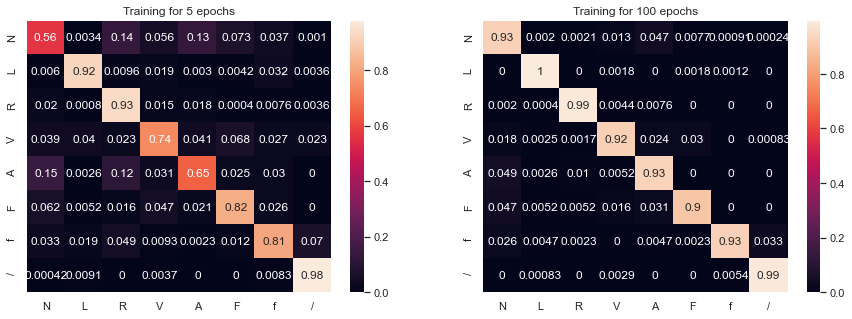

In [39]:
# Visualize the confusion matrices for both models:
fig, ax = plt.subplots(1, 2, figsize = (15, 5))
categories = ['N','L','R','V','A','F','f','/']

# Model trained for only 5 epochs:
cm = confusion_matrix(attn_actual_value, attn_predict_5, normalize = 'true')
sns.heatmap(cm, annot=True, xticklabels = categories, yticklabels=categories, ax = ax[0])
ax[0].set_title('Training for 5 epochs')

# Model trained for 100 epochs:
cm = confusion_matrix(attn_actual_value, attn_predict_100, normalize = 'true')
sns.heatmap(cm, annot=True, xticklabels = categories, yticklabels=categories, ax = ax[1])
ax[1].set_title('Training for 100 epochs')
fig.savefig('lstm_attention_cm_ecg_data.jpg', dpi = 400)

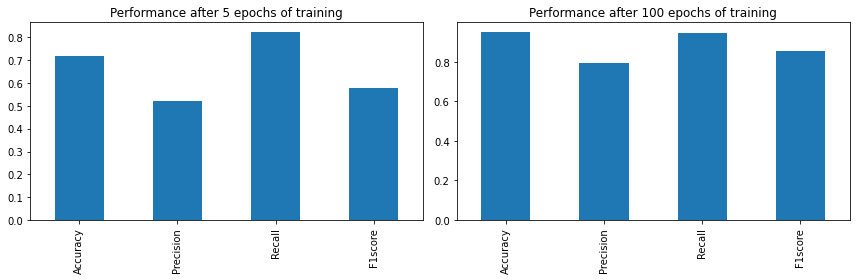

In [15]:
# Visualize the accuracy, precision, recall, and F1-score:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
results_5_df = pd.DataFrame(data = results_5, index = ('Model','Accuracy','Precision','Recall','F1score','CM'))
results_5_df[0][1:5].plot(kind = 'bar', ax = ax[0])
ax[0].set_title('Performance after 5 epochs of training')

results_100_df = pd.DataFrame(data = results_100, index = ('Model','Accuracy','Precision','Recall','F1score','CM'))
results_100_df[0][1:5].plot(kind = 'bar', ax = ax[1])
ax[1].set_title('Performance after 100 epochs of training')
plt.tight_layout()
fig.savefig('lstm_attention_metrics_ecg_data.jpg', dpi = 400)